# Chapter 12. k-Nearest Neighbors

In [120]:
from __future__ import division
from collections import Counter
from linear_algebra import distance
from statistics import mean
import math, random
import matplotlib.pyplot as plt

Imagine that you're trying to predict how I'm going to vote in the next presidential election.  
If you know nothing else about me, one sensible approach is to look at how my *neighbors* are planning to vote.  
Now imagine that you know more about me than just geography -- my age, my income, marital status, and so on.  
To the extent that my behavior is influenced (or characterized) by those things, looking just at my neighbors who are close to me among all of those dimensions seems likely to be an even better predictor than looking at all of my neighbors.  
This is the idea behind [nearest neighbors classification](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

## The Model

Nearest neighbors requires:
- Some notion of distance.
- An assumption that points that are close to one another are similar. 

KNN deliberately neglects a lot of information, since the prediction for each new point depends only on the handful of points closest to it.  
What's more, KNN is probably not going to help you understand the drivers of whatever phenomenon you're looking at.  
In the general situation, we have some data points and a corresponding set of labels that can be binary (eg.T/F), categorical, or numeric.  

For our example, the data points will be vectors, so we can use the `distance` function from Chapter 4.  
Let's say we've picked a number `k` like 3 or 5.  
When we want to classify some new data point, we find the `k` nearest labeled points and let them vote on the new output.  
To do this, we need a function that counts votes:

In [121]:
def raw_majority_vote(labels):
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

That's a good start, but what about tie votes?  
We have several options:
- Pick one of the winners at random.
- Weight the votes by distance and pick the weighted winner.
- Reduce `k` until we find a unique winner.  

Let's implement the third option:

In [122]:
def majority_vote(labels):
    """ assumes that labels are ordered from nearest to farthest """
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count for count in vote_counts.values() if count == winner_count])
    if num_winners == 1:
        return winner   # unique winner, so return it
    else:
        return majority_vote(labels[:-1])   # try again without the furthest data point

This approach will work eventually, since in the worst case we go all the way down to just one label, at which point that one label wins.  
With this function, it's easy to create a classifier:

In [123]:
def knn_classify(k, labeled_points, new_point):
    """ each labeled point should be a pair (point, label) """
    # order the labeled points from nearest to farthest
    by_distance = sorted(labeled_points,
                         key=lambda (point, _):
                         distance(point, new_point))
    # find the labels for the closest k
    k_nearest_labels = [label for _, label in by_distance[:k]]
    # and let them vote
    return majority_vote(k_nearest_labels)

Let's take a look at how this works.

## Example: Favorite Languages

The results of the DataSciencester user survey are back, and we have found the preferred programming languages of our users in a number of large cities:

In [124]:
# each entry is ([longitude, latitude], favorite_language)
cities = [(-86.75,33.5666666666667,'Python'),
          (-88.25,30.6833333333333,'Python'),
          (-112.016666666667,33.4333333333333,'Java'),
          (-110.933333333333,32.1166666666667,'Java'),
          (-92.2333333333333,34.7333333333333,'R'),
          (-121.95,37.7,'R'),
          (-118.15,33.8166666666667,'Python'),
          (-118.233333333333,34.05,'Java'),
          (-122.316666666667,37.8166666666667,'R'),
          (-117.6,34.05,'Python'),
          (-116.533333333333,33.8166666666667,'Python'),
          (-121.5,38.5166666666667,'R'),
          (-117.166666666667,32.7333333333333,'R'),
          (-122.383333333333,37.6166666666667,'R'),
          (-121.933333333333,37.3666666666667,'R'),
          (-122.016666666667,36.9833333333333,'Python'),
          (-104.716666666667,38.8166666666667,'Python'),
          (-104.866666666667,39.75,'Python'),
          (-72.65,41.7333333333333,'R'),
          (-75.6,39.6666666666667,'Python'),
          (-77.0333333333333,38.85,'Python'),
          (-80.2666666666667,25.8,'Java'),
          (-81.3833333333333,28.55,'Java'),
          (-82.5333333333333,27.9666666666667,'Java'),
          (-84.4333333333333,33.65,'Python'),
          (-116.216666666667,43.5666666666667,'Python'),
          (-87.75,41.7833333333333,'Java'),
          (-86.2833333333333,39.7333333333333,'Java'),
          (-93.65,41.5333333333333,'Java'),
          (-97.4166666666667,37.65,'Java'),
          (-85.7333333333333,38.1833333333333,'Python'),
          (-90.25,29.9833333333333,'Java'),
          (-70.3166666666667,43.65,'R'),
          (-76.6666666666667,39.1833333333333,'R'),
          (-71.0333333333333,42.3666666666667,'R'),
          (-72.5333333333333,42.2,'R'),
          (-83.0166666666667,42.4166666666667,'Python'),
          (-84.6,42.7833333333333,'Python'),
          (-93.2166666666667,44.8833333333333,'Python'),
          (-90.0833333333333,32.3166666666667,'Java'),
          (-94.5833333333333,39.1166666666667,'Java'),
          (-90.3833333333333,38.75,'Python'),
          (-108.533333333333,45.8,'Python'),
          (-95.9,41.3,'Python'),
          (-115.166666666667,36.0833333333333,'Java'),
          (-71.4333333333333,42.9333333333333,'R'),
          (-74.1666666666667,40.7,'R'),
          (-106.616666666667,35.05,'Python'),
          (-78.7333333333333,42.9333333333333,'R'),
          (-73.9666666666667,40.7833333333333,'R'),
          (-80.9333333333333,35.2166666666667,'Python'),
          (-78.7833333333333,35.8666666666667,'Python'),
          (-100.75,46.7666666666667,'Java'),
          (-84.5166666666667,39.15,'Java'),
          (-81.85,41.4,'Java'),
          (-82.8833333333333,40,'Java'),
          (-97.6,35.4,'Python'),
          (-122.666666666667,45.5333333333333,'Python'),
          (-75.25,39.8833333333333,'Python'),
          (-80.2166666666667,40.5,'Python'),
          (-71.4333333333333,41.7333333333333,'R'),
          (-81.1166666666667,33.95,'R'),
          (-96.7333333333333,43.5666666666667,'Python'),
          (-90,35.05,'R'),
          (-86.6833333333333,36.1166666666667,'R'),
          (-97.7,30.3,'Python'),(-96.85,32.85,'Java'),
          (-95.35,29.9666666666667,'Java'),
          (-98.4666666666667,29.5333333333333,'Java'),
          (-111.966666666667,40.7666666666667,'Python'),
          (-73.15,44.4666666666667,'R'),
          (-77.3333333333333,37.5,'Python'),
          (-122.3,47.5333333333333,'Python'),
          (-89.3333333333333,43.1333333333333,'R'),
          (-104.816666666667,41.15,'Java')]

cities = [([longitude, latitude], language) for longitude, latitude, language in cities]
def plot_state_borders(plt, color='0.8'):
    # Plotting state borders requires a bit of homework, so I'm skipping that for now.
    # http://matplotlib.org/basemap/users/geography.html
    # http://matplotlib.org/basemap/users/examples.html
    pass

The VP of Community Engagement wants to know if we can use these results to predict the favorite programming languages for places that *weren't* part of the survey.  
As usual, a good first step is plotting the data:

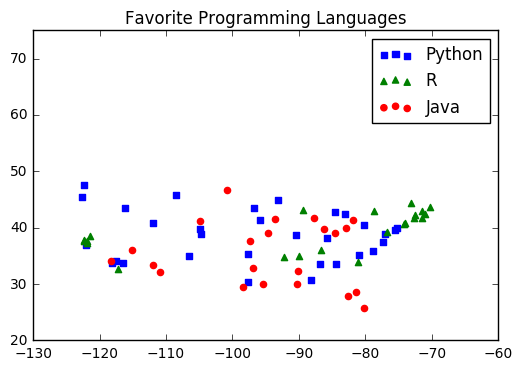

In [125]:
# key is language, value is pair (longitudes, latitudes)
plots = { "Java" : ([], []), "Python" : ([], []), "R" : ([], []) }
# we want each language to have a different marker and color 
markers = { "Java" : "o", "Python" : "s", "R" : "^" }
colors  = { "Java" : "r", "Python" : "b", "R" : "g" }
for (longitude, latitude), language in cities:
    plots[language][0].append(longitude)
    plots[language][1].append(latitude)
# create a scatter series for each language
for language, (x, y) in plots.iteritems():
    plt.scatter(x, y, color=colors[language], marker=markers[language], label=language, zorder=10)
plot_state_borders(plt)     # pretend we have a function that does this
plt.legend(loc=0)           # let matplotlib choose the location
plt.axis([-130,-60,20,75])  # set the axes
plt.title("Favorite Programming Languages")
plt.show()

It looks like nearby places tend to like the same language, so KNN seems like a reasonable choice for a predictive model.  
For starters, let's look at what happens if we try to predict each city's preferred language using its neighbors other than itself:

In [126]:
# try several different values for k
for k in [1,3,5,7]:
    num_correct = 0
    for city in cities:
        location, actual_language = city
        other_cities = [other_city for other_city in cities if other_city != city]
        predicted_language = knn_classify(k, other_cities, location)
        if predicted_language == actual_language:
            num_correct += 1
    print k, "neighbor[s]:", num_correct, "correct out of", len(cities)

1 neighbor[s]: 40 correct out of 75
3 neighbor[s]: 44 correct out of 75
5 neighbor[s]: 41 correct out of 75
7 neighbor[s]: 35 correct out of 75


It appears that 3-nearest neighbors performs the best, giving the correct result ~59% of the time.  
Now we can look at what regions would get classified to which languages under each nearest neighbors scheme.  
That can be done by classifying and entire grid worth of points, and then plotting them as we did the cities:

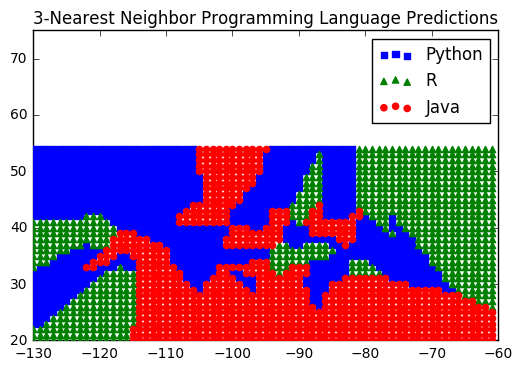

In [127]:
plots = { "Java" : ([], []), "Python" : ([], []), "R" : ([], []) }
k = 1  # or 3, 5, 7, and so on
for longitude in range(-130, -60):
    for latitude in range(20, 55):
        predicted_language = knn_classify(k, cities, [longitude, latitude])
        plots[predicted_language][0].append(longitude)
        plots[predicted_language][1].append(latitude)
# create a scatter series for each language
for language, (x, y) in plots.iteritems():
    plt.scatter(x, y, color=colors[language], marker=markers[language], label=language, zorder=10)
plot_state_borders(plt)     # pretend we have a function that does this
plt.legend(loc=0)           # let matplotlib choose the location
plt.axis([-130,-60,20,75])  # set the axes
plt.title("3-Nearest Neighbor Programming Language Predictions")
plt.show()       

As you change `k` in the plot above from 1 to 3, 3 to 5, and so on, you will notice that the boundaries between programming languages become smoother.

## The Curse of Dimensionality

KNN runs into trouble in higher dimensions thanks to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), which boils down to the fact that high-dimensional spaces are so vast.  
As the dimensionality increases, the volume of the space increases so fast that the available data become sparse, and the points in high-dimensional spaces tend not to be close to one another at all.  
One way to se this is by randomly generating pairs of points in the d-dimensional "unit cube" in a variety of dimensions, and calculating the distances between them.  
Time (once again) to generate some random points:

In [128]:
def random_point(dim):
    return [random.random() for _ in range(dim)]

and write a function to generate the distances:

In [129]:
def random_distances(dim, num_pairs):
    return [distance(random_point(dim), random_point(dim)) for _ in range(num_pairs)]

For every dimension from 1 to 100, compute 10,000 distances and use those to calculate the average distance between points and the minimum distance between points in each dimension:

In [130]:
dimensions = range(1, 101)
avg_distances = []
min_distances  = []
random.seed(0)
for dim in dimensions:
    distances = random_distances(dim, 10000)   # 10,000 random pairs
    avg_distances.append(mean(distances))      # track the average
    min_distances.append(min(distances))       # track the minimum
    
print avg_distances
print min_distances

[0.3310009902894413, 0.5239565117360907, 0.6627400615351537, 0.7785672542798419, 0.877091664458287, 0.9672340920433726, 1.0523391983782242, 1.1269047458254557, 1.1988392565753736, 1.2685107307510508, 1.335739817686532, 1.3901775036846789, 1.450447110138265, 1.510785914151384, 1.5627508066886946, 1.6173640116377452, 1.6656891497805761, 1.7204805046888398, 1.7597299196155094, 1.8092000423588965, 1.8536077211329256, 1.8992668248341547, 1.9416678769219091, 1.9798782638749814, 2.028275560729772, 2.0679992235004616, 2.107317483257346, 2.1433430857302422, 2.1899499568316605, 2.2241204482989994, 2.2616757026553236, 2.292505240413079, 2.330648107078456, 2.3668774621512356, 2.405482843476534, 2.434818703659448, 2.469351290460494, 2.5064540534200774, 2.537020701883388, 2.5737533238942647, 2.6009549527321023, 2.6317153314136483, 2.6622320491341696, 2.69490173795784, 2.7294674252858915, 2.755780596380261, 2.786061992321655, 2.8176652823449806, 2.849453027824825, 2.876489918268588, 2.908017567350619

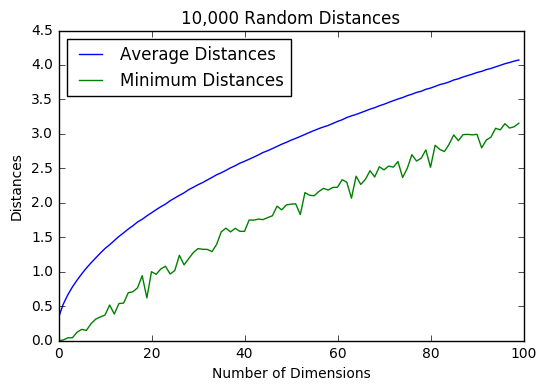

In [131]:
plt.plot(avg_distances, label="Average Distances")
plt.plot(min_distances, label="Minimum Distances")
plt.title("10,000 Random Distances")
plt.xlabel("Number of Dimensions")
plt.ylabel("Distances")
plt.legend(loc=0)
plt.show()

As the number of dimensions increases, the average distance between points increases.  
A bigger problem is the ratio between the closest distance and the average distance:

In [132]:
min_avg_ratio = [min_dist / avg_dist for min_dist, avg_dist in zip(min_distances, avg_distances)]
min_avg_ratio[:5]

[2.4010264196729895e-05,
 0.012375993376885747,
 0.05866675835687187,
 0.052702840066952916,
 0.13806017036605744]

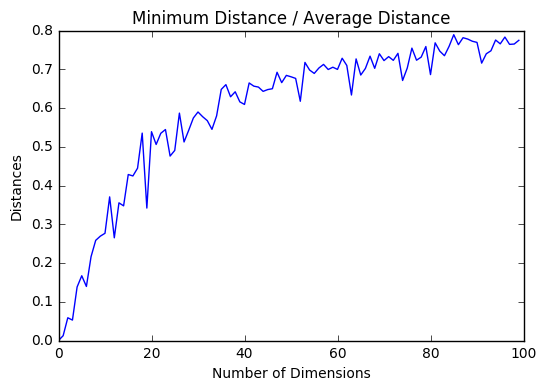

In [133]:
plt.plot(min_avg_ratio)
plt.title("Minimum Distance / Average Distance")
plt.xlabel("Number of Dimensions")
plt.ylabel("Distances")
plt.show()

Now pay attention.  
In low-dimensional data sets, the closest points tend to be much closer than average.  
*But* two points are close only if they're close in *every* dimension, and each extra dimension is another opportunity for each point to be further away from every other point.  
Think about the theory of an expanding universe, with all of those far away stars and galaxies racing even further away from one another.  
When you have a lot of dimensions, it is very likely that even the closest points aren't much closer than average.  
This means that two points being close to one another doesn't mean very much.

A different way of thinking about the problem involves the sparsity of higher-dimensional spaces.  
If you pick 50 random numbers between 0 and 1, you will probably get a pretty good sample of the unit interval:

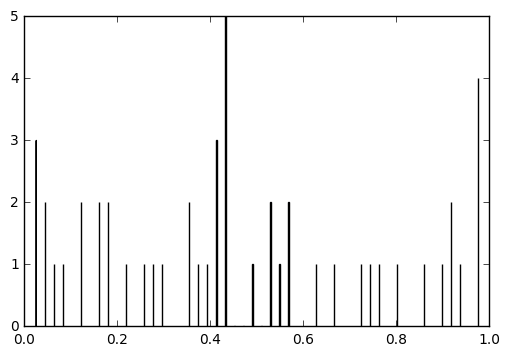

In [134]:
points = [random.random() for i in range(50)]
plt.hist(points, rwidth=.01, bins=50)
plt.show()

If you pick 50 random points in the unit square, you'll get less coverage:

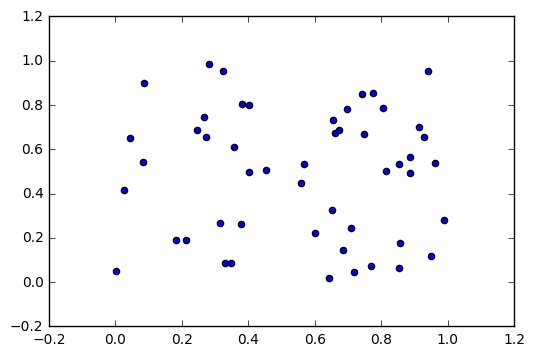

In [135]:
x = [random.random() for i in range(50)]
y = [random.random() for i in range(50)]
plt.scatter(x, y)
plt.show()

And in three dimensions even less:

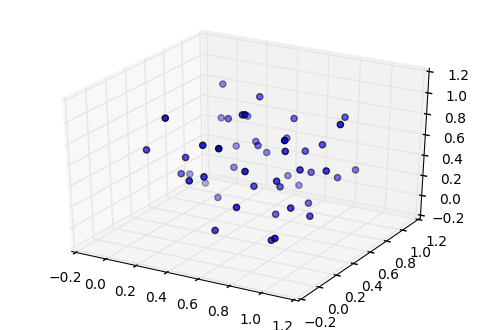

In [136]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = [random.random() for i in range(50)]
y = [random.random() for i in range(50)]
z = [random.random() for i in range(50)]
ax.scatter(x, y, z)
plt.show()

Even with only three dimensions plotted, there are starting to be large empty spaces with no points near them.  
Those large empty spaces represent regions far from all of the points that you want to use in your predictions.  
Unless you can get more data -- a **lot** more data -- it is a good idea to do some kind of dimensionality reduction when using KNN in higher dimensions.

## For Further Exploration

scikit-learn has a number of [nearest neighbor](http://scikit-learn.org/stable/modules/neighbors.html) models.